<a href="https://colab.research.google.com/github/SalimuKabogere/XAI/blob/main/kd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/My Drive/Dataset4"

# Verify dataset structure
os.listdir(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Testing', 'Validation', 'Training', 'testing', 'processed', 'raw']

In [4]:
# If dataset is stored in Google Drive, mount it
from google.colab import drive
# drive.mount('/content/drive')  # Uncomment if using Google Drive

# Define dataset path (Ensure dataset is uploaded to /content/Dataset)
DATASET_PATH = "/content/drive/My Drive/Dataset4"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
BATCH_SIZE = 32

train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "Training"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "Validation"), transform=transform)
# test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "Testing"), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes: {train_dataset.classes}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Classes: ['Fake', 'Real']
Train: 64, Val: 16


In [5]:
# Load pretrained ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Load Pretrained ViT (Updated for newer Torch versions)
vit_teacher = models.get_model('vit_b_16', pretrained=True).to(device)

# Modify classifier head for 2 classes (Real, Fake)
num_features = vit_teacher.heads.head.in_features
vit_teacher.heads.head = nn.Linear(num_features, 2).to(device)

# Freeze ViT parameters (No training for Teacher model)
for param in vit_teacher.parameters():
    param.requires_grad = False

print("Teacher Model (ViT) Loaded")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Teacher Model (ViT) Loaded


In [7]:
# Define CNN model
class CNNStudent(nn.Module):
    def __init__(self):
        super(CNNStudent, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten for FC layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_student = CNNStudent().to(device)
print("Student Model (CNN) Initialized")

Student Model (CNN) Initialized


In [8]:
# Define knowledge distillation loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion_ce = nn.CrossEntropyLoss()
        self.criterion_kl = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_logits, teacher_logits, labels):
        soft_targets = F.log_softmax(student_logits / self.temperature, dim=1)
        teacher_targets = F.softmax(teacher_logits / self.temperature, dim=1)
        loss_kl = self.criterion_kl(soft_targets, teacher_targets)
        loss_ce = self.criterion_ce(student_logits, labels)
        loss = (1 - self.alpha) * loss_ce + (self.alpha * self.temperature * self.temperature) * loss_kl
        return loss

In [9]:
# Train the student model using KD
def train_student(model, teacher, train_loader, optimizer, loss_fn, epochs=2):
    model.train()
    teacher.eval()
    train_loss = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                teacher_outputs = teacher(images)
            student_outputs = model(images)
            loss = loss_fn(student_outputs, teacher_outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return train_loss


Epoch 1/2: 100%|██████████| 2/2 [01:32<00:00, 46.27s/it]


Epoch 1/2 - Loss: 25.5183


Epoch 2/2: 100%|██████████| 2/2 [01:19<00:00, 39.65s/it]


Epoch 2/2 - Loss: 1.0517


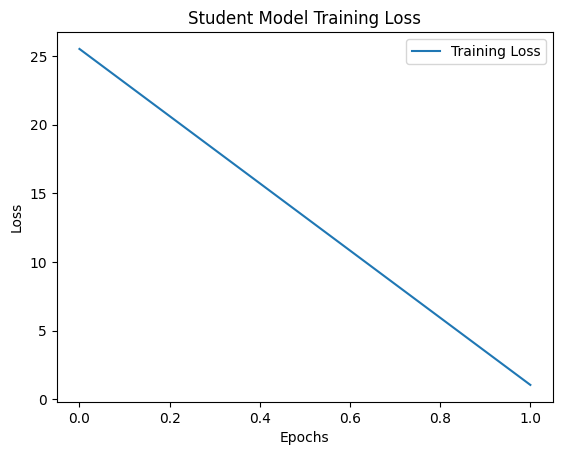

In [10]:
# Define Optimizer and Train
optimizer = optim.Adam(cnn_student.parameters(), lr=0.001)
loss_fn = DistillationLoss(temperature=3.0, alpha=0.5)
EPOCHS = 2
train_loss = train_student(cnn_student, vit_teacher, train_loader, optimizer, loss_fn, EPOCHS)

# Plot Loss Curve
plt.plot(range(EPOCHS), train_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Student Model Training Loss")
plt.legend()
plt.show()


In [11]:
# Define the save path in Colab
model_save_path = "/content/drive/My Drive/kd_fake_currency_model.pth"

# Save the trained student model
torch.save(cnn_student.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/My Drive/kd_fake_currency_model.pth
